## Imports

In [123]:
import pandas as pd

import io #input output library

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import LocallyLinearEmbedding

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

### Read Data

In [7]:
crabs_data = pd.read_csv("./crabs.csv")

Some EDA

In [8]:
crabs_data.head()

,sp,sex,index,FL,RW,CL,CW,BD
0,B,M,1,8.1,6.7,16.1,19.0,7.0
1,B,M,2,8.8,7.7,18.1,20.8,7.4
2,B,M,3,9.2,7.8,19.0,22.4,7.7
3,B,M,4,9.6,7.9,20.1,23.1,8.2
4,B,M,5,9.8,8.0,20.3,23.0,8.2


In [10]:
crabs_data.tail()

,sp,sex,index,FL,RW,CL,CW,BD
195,O,F,46,21.4,18.0,41.2,46.2,18.7
196,O,F,47,21.7,17.1,41.7,47.2,19.6
197,O,F,48,21.9,17.2,42.6,47.4,19.5
198,O,F,49,22.5,17.2,43.0,48.7,19.8
199,O,F,50,23.1,20.2,46.2,52.5,21.1


In [11]:
crabs_data.shape

(200, 8)

## Data Clean up

In [14]:
crabs_data = crabs_data.rename(
    columns={
        'sp': 'species',
        'FL': 'Frontal Lobe',
        'RW': 'Rear Width',
        'CL': 'Carapace Midline',
        'CW': 'Maximum Width',
        'BD': 'Body Depth' 
    }
)

In [16]:
crabs_data.head()

,species,sex,index,Frontal Lobe,Rear Width,Carapace Midline,Maximum Width,Body Depth
0,B,M,1,8.1,6.7,16.1,19.0,7.0
1,B,M,2,8.8,7.7,18.1,20.8,7.4
2,B,M,3,9.2,7.8,19.0,22.4,7.7
3,B,M,4,9.6,7.9,20.1,23.1,8.2
4,B,M,5,9.8,8.0,20.3,23.0,8.2


Replace some values using **MAP**

In [18]:
crabs_data["sex"] = crabs_data["sex"].map(
    {
        "M":"Male", "F": "Female"
    }
)

crabs_data["species"] = crabs_data["species"].map(
    {
        "B": "Blue", "O": "Orange"
    }
)

## GOAL

Is to sepearte 200 crabs into 4 classes. Male/Female, blue/orange. 

We will do it with LLE this time instead of PCA. 

## Apply LLE

First, make a class column. This combines the mult-dimensional data into one output: Species + Sex.

In [22]:
crabs_data["class"] = crabs_data.species + crabs_data.sex

In [23]:
crabs_data.head()

,species,sex,index,Frontal Lobe,Rear Width,Carapace Midline,Maximum Width,Body Depth,class
0,Blue,Male,1,8.1,6.7,16.1,19.0,7.0,BlueMale
1,Blue,Male,2,8.8,7.7,18.1,20.8,7.4,BlueMale
2,Blue,Male,3,9.2,7.8,19.0,22.4,7.7,BlueMale
3,Blue,Male,4,9.6,7.9,20.1,23.1,8.2,BlueMale
4,Blue,Male,5,9.8,8.0,20.3,23.0,8.2,BlueMale


We can see the distribution of these 4 classes. All of them have equal data.

In [27]:
crabs_data["class"].value_counts()

class
BlueMale        50
BlueFemale      50
OrangeMale      50
OrangeFemale    50
Name: count, dtype: int64

Let's focus on the data columns

In [34]:
data_columns = [
    "Frontal Lobe", 
    "Rear Width", 
    "Carapace Midline",
    "Maximum Width",
    "Body Depth"
]

**LLE Description** 

We want to project this data that is currently D = 5 dimensions into a lower dimensional space that preservces distances between neighbors.  

**IT IS IMPORTANT to work with data at the SAME SCALE** or large values could really throw off the model. **TO DO THAT** we avoid these problems using **MinMaxScaler**. This **scales values of each feature to a given range**.

Work on a copy.

In [32]:
crabs_min_max = crabs_data.copy()

Transform data columns only. 

In [35]:
crabs_min_max[data_columns] = MinMaxScaler().fit_transform(crabs_min_max[data_columns])

Apply LLE.

In [62]:
# Define the engine (class)
lle = LocallyLinearEmbedding(
    n_components=2,
    n_neighbors=15
)

In [63]:
# Returns Array of LLE.
# Only data is given back, no columns or meanings.
# Remember this is a projecion into a lower dimensional manifold
# whose base vectors we don't really have an idea about, they are from
# the solution of an eigen-vector problem.
crabs_lle = lle.fit_transform(
    crabs_min_max[data_columns]
)

Attach the data to the min_max re-scaled DF

In [46]:
crabs_min_max[["LLE1", "LLE2"]] = crabs_lle

In [47]:
crabs_min_max.head()

,species,sex,index,Frontal Lobe,Rear Width,Carapace Midline,Maximum Width,Body Depth,class,LLE1,LLE2
0,Blue,Male,1,0.056604,0.014599,0.042553,0.050667,0.058065,BlueMale,-0.145449,0.060973
1,Blue,Male,2,0.100629,0.087591,0.103343,0.098667,0.083871,BlueMale,-0.133111,0.057664
2,Blue,Male,3,0.125786,0.094891,0.130699,0.141333,0.103226,BlueMale,-0.126506,0.053316
3,Blue,Male,4,0.150943,0.102190,0.164134,0.160000,0.135484,BlueMale,-0.118650,0.028331
4,Blue,Male,5,0.163522,0.109489,0.170213,0.157333,0.135484,BlueMale,-0.117088,0.022013


### Do some plotting

<Axes: xlabel='LLE1', ylabel='LLE2'>

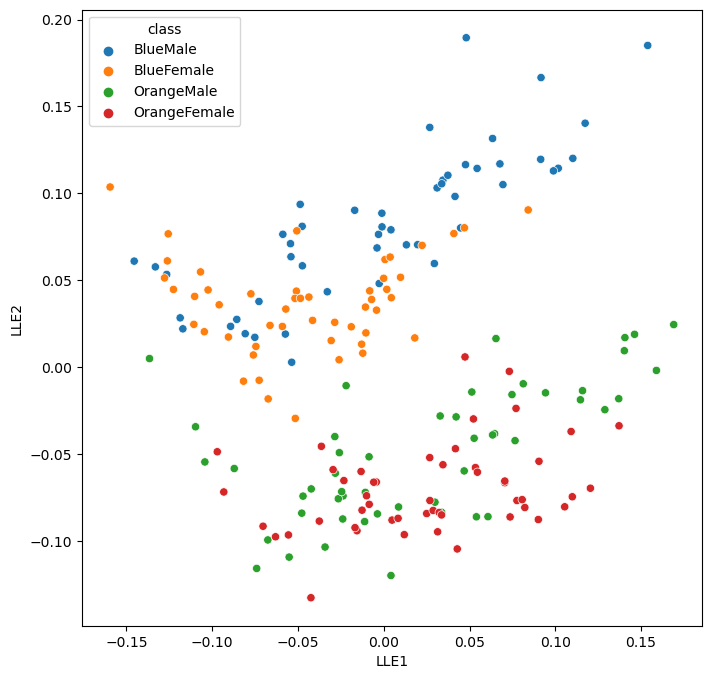

In [51]:
fig = plt.figure(figsize=(8,8))
sns.scatterplot(
    x="LLE1", y="LLE2", hue="class", data=crabs_min_max
)

It's easy to see they blue male and blue female share similar features, and on these axes it's relatively easy to segragate them by category. 

The red and green for exmaple, are alos clustered together, likely because they are coming from the same species. 

This type of "best flattening" according to the data given, is what we are looking for. We just went from 5 dimensions to 2 dimensions while clustering together the data in a meaninful way as it was in the 5-Dimensional space.

? Did we complete the objective? 

Separate 200 crabs into four classes. YES.

### View Reconstruction Error

The reconstruction error is this Frobenius norm.

$ E(W) = \sum_i \left| \vec{Y}_i - \sum_j W_{ij} \vec{Y}_j   \right|^2 $

In [64]:
lle.reconstruction_error_

2.153028802414812e-06

## Re-apply LLE but with 3-Dimensions

In [104]:
# Define the LLE Object/machine again, with 

# 3D components

lle = LocallyLinearEmbedding(
    n_components=3,
    n_neighbors=15
)

Reuse the crabs data and apply the transformation.

In [105]:
crabs_lle_3d = lle.fit_transform(
    crabs_min_max[data_columns]
)


Add the data to the transformation.

In [106]:
crabs_min_max[
    ["LLE1_3D", "LLE2_3D", "LLE3_3D"]
] = crabs_lle_3d

Check the reconstruction error.

In [107]:
lle.reconstruction_error_

1.5214133597455878e-05

### Now Plot the Reconstruction

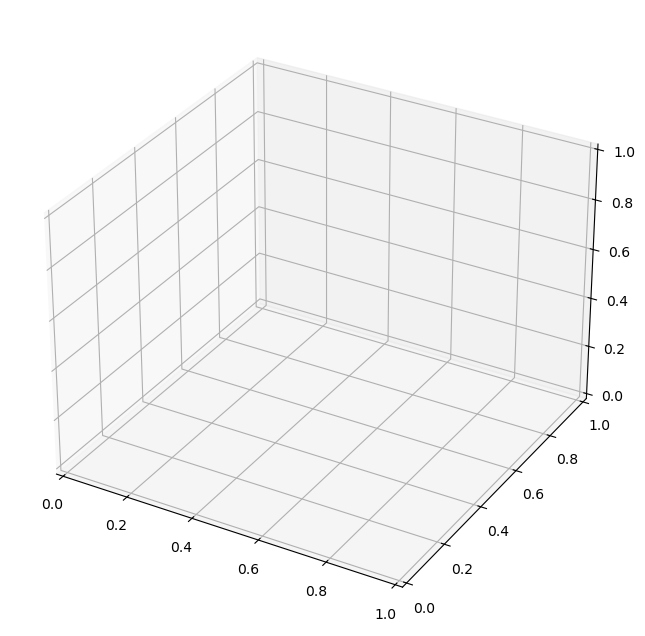

In [108]:
# Figure and 3D axes w matplotlib
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')

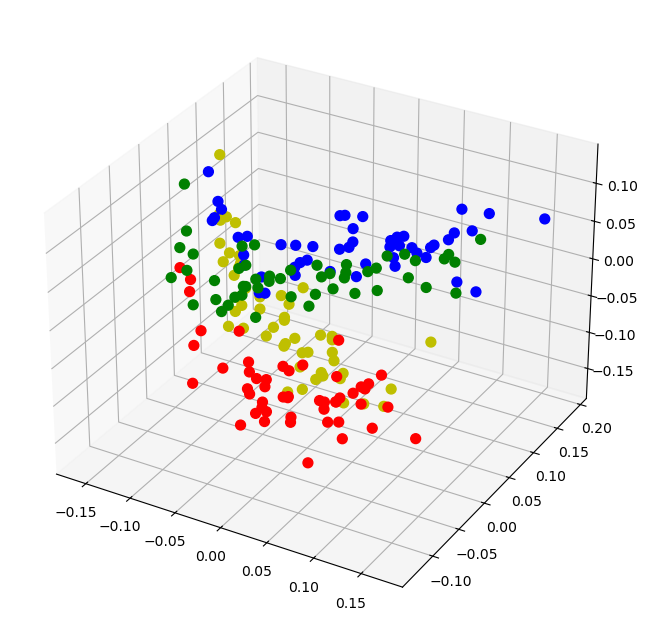

In [119]:
# coloring scheme for scatter plot 3D
colors_crabs = {
    "BlueFemale": "y",
    "BlueMale": "b",
    "OrangeFemale": "r",
    "OrangeMale": "g"
}


#
x_data = crabs_min_max.LLE1_3D
# 
y_data = crabs_min_max.LLE2_3D
# 
z_data = crabs_min_max.LLE3_3D


# Figure and 3D axes w matplotlib
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


plt.scatter(
    crabs_min_max.LLE1_3D, 
    crabs_min_max.LLE2_3D, 
    zs=crabs_min_max.LLE3_3D,
    depthshade=False, # Visualize all data without any opacity changes.
    c=crabs_data["class"].apply(lambda x: colors_crabs[x]), #colors mapping. Given a class, apply this mapping defined above that maps to a color key of the scatter method.
    s=50
)



### Visualize with PLOTLY Express

In [125]:
fig = px.scatter_3d(
    crabs_min_max,
    x="LLE1_3D", 
    y="LLE2_3D",
    z="LLE3_3D",
    color="class"
)

fig.show()